# **Appendix B: 15 Puzzle**
---
[![GitHub Repository](https://img.shields.io/badge/-Repository-2dba4e?logo=github&style=flat)](https://github.com/kyo-takano/EfficientCube)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://console.paperspace.com/github/kyo-takano/EfficientCube/blob/main/notebooks/EfficientCube-15_Puzzle.ipynb)

This notebook is intended to demonstrate the proposed method and to allow for reproducible experiments.

For the purpose of demonstration, the number of training steps is set to $10000$ and the beam width is set to $2^{12}$ by default.
If you want to replicate our best reported result, set ```TrainConfig.num_train_steps``` to $100000$ and ```top_k``` to $2^{18}$. Note, however, that it will take several days to finish both training and inference.

See paper for theoretical & experimental details.

### **Training & Inference**

The DNN is trained to predict the last move of a scramble based on the corresponding problem state. \
In inference, inverses of predicted last moves are applied to given states.

Following the published result,`SearchConfig.eval__` is set to `"softmax"` by default. 
However, you may want to change this to `"cumprod"` to get better solutions & finish inferences faster (see [📢 UPDATE on 15 Puzzle](https://github.com/kyo-takano/EfficientCube#-update-on-15-puzzle) for details).

### **Test**

The trained model is evaluated on [500 test cases provided by Forest Agostinelli, et al. (2019)](https://github.com/forestagostinelli/DeepCubeA/) and compared to the result of DeepCubeA and an optimal solver in three respects: 
1.  solution lengths 
1.  number of nodes 
1.  computation times

---
### ***Q. How much time does this notebook take?***

For reference, it took **about 6 hours** to run the entire notebook, including training, inference, and comparison.

Computational resources: one 4-core CPU & one GPU ([NVIDIA Tesla P100 PCIe 16GB](https://images.nvidia.com/content/tesla/pdf/nvidia-tesla-p100-PCIe-datasheet.pdf)).

## Setup

Parameters

In [ ]:
# problem
SCRAMBLE_LENGTH = 80
# training
class TrainConfig:
    learning_rate = 1e-3
    batch_size_per_depth = 1000
    num_train_steps = 10000
    interval_steps_save = 1000
    interval_steps_plot = 100
    scramble_length = SCRAMBLE_LENGTH

# inference
class SearchConfig:
    ## The wider the beam search, the more time required, but the shorter the solution.
    beam_width = 2**12
    ## This can be any number greater than or equal to the Gods Number.
    max_depth = SCRAMBLE_LENGTH * 2
    eval__ = "softmax"


Modules & Utilities

In [ ]:
#@title
import os
import time
import random
import pickle
import numpy as np
import multiprocessing
from scipy.special import softmax
from copy import deepcopy
from tqdm import tqdm, trange
from IPython.display import clear_output

import torch
from torch import nn
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
print(f'multiprocessing.cpu_count(): {multiprocessing.cpu_count()}')
!nvidia-smi -L


device: cuda:0
multiprocessing.cpu_count(): 4
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-aaf10508-9217-06d4-2f35-fe9a40a5c472)


In [ ]:
#@title
import matplotlib.pyplot as plt
from cycler import cycler
plt.rcParams["axes.prop_cycle"] = cycler(color=["#212121", "#2180FE", "#EB4275"])

def plt_history(h):
    fig, axes = plt.subplots(1, 1, figsize=[4, 4])
    axes.plot(h)
    axes.set_xscale("log")
    axes.set_title("Loss")
    plt.show()

def regression_coef(x, y):
    coef = np.array(y) / np.array(x)
    coef = np.mean(np.squeeze(coef))
    return coef

def plot_result(solutions_all, num_nodes_all, times_all):
    fig, ax = plt.subplots(2, 3, figsize=(16, 9))
    ax = ax.ravel()
    for i, result in enumerate([solutions_all, num_nodes_all, times_all]):
        result = [e for e in result if e is not None]
        if i == 0:  # soltions
            result = [len(e) for e in result if e is not None]
            ax[i].axvline(
                np.mean(result),
                color="#00ffff",
                label=f"mean={round(np.mean(result),3)}",
            )
            result = {i: result.count(i)
                      for i in range(min(result), max(result) + 1)}
            ax[i].bar(
                result.keys(),
                result.values(),
                width=1.0,
                label=f"Success: {len([len(e) for e in solutions_all if e is not None])}/{len(solutions_all)}",
            )
            ax[i].legend()
            ax[i].set_xlabel("Solution length")
            ax[i].set_ylabel("Frequency")
        else:
            ax[i].hist(result)
            ax[i].axvline(
                np.mean(result),
                color="#00ffff",
                label=f"mean={round(np.mean(result),3)}",
            )
            ax[i].legend()
            if i == 1:
                ax[i].set_xlabel("No. of nodes")
            else:
                ax[i].set_xlabel("Calculation time (s)")

    solution_lengths, num_nodes, times = [
        [e for e in result if e is not None]
        for result in [solutions_all, num_nodes_all, times_all]
    ]
    solution_lengths = [len(e) for e in solution_lengths]

    for (xlabel, ylabel), (x, y) in [
        [("Solution lengths", "No. of nodes"), (solution_lengths, num_nodes)],
        [("No. of nodes", "Calculation time (s)"), (num_nodes, times)],
        [("Calculation time (s)", "Solution lengths"), (times, solution_lengths)],
    ]:
        i += 1
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        x_range = np.linspace(0, max(x), 100)
        ax[i].plot(
            x_range,
            x_range * regression_coef(x, y),
            label=f"slope={round(regression_coef(x, y), 5)}",
            color="#00ffff",
        )
        ax[i].scatter(x, y)
        ax[i].legend()

    plt.show()


## Environment: 15 Puzzle

In [ ]:
import numpy as np
import random

class Puzzle15(object):
    def __init__(self):
        self.DTYPE = np.int64

        # define state and goal
        self.reset() # state
        self.goal = np.concatenate((np.arange(1, 4 * 4, dtype=self.DTYPE), [0]))

        self.moves = ['U', 'D', 'L', 'R']
        self.moves_inference = ['D','U','R','L']

        # opposite faces
        self.pairing = {
            'R':'L',
            'L':'R',
            'U':'D',
            'D':'U',
        }
        self.moves_subsequent = {
            m:[v for v in self.moves if v!=self.pairing[m]] for m in self.moves
        } 
        # vectorize the sticker group replacement operations
        self.__vectorize_moves()

    def reset(self):
        self.state = np.concatenate((np.arange(1, 4 * 4, dtype=self.DTYPE), [0]))

    def is_solved(self):
        return np.all(self.state == self.goal)

    def state_to_batch(self):
        return np.expand_dims(self.state, axis=0)

    def finger(self, action):
        if isinstance(action, str):
            # action = self.moves.index(self.pairing[action])
            action = self.moves.index(action)
        # target: empty slot
        target_index = np.squeeze(np.where(self.state == 0))
        # source: to be the empty slot
        source_index = self.swap_zeros[target_index, action]
        # swap.
        self.state[target_index], self.state[source_index] = self.state[source_index], 0

    def scrambler(self, scramble_length):
        """
            A generator function yielding the state and scramble
        """
        while True:
            # reset the self.state, scramble, and retun self.state and scramble moves
            self.reset()
            scramble = []
            for i in range(scramble_length):
                target_loc = np.where(self.state.reshape(4, 4) == 0)
                for _ in iter(int,1):
                    if scramble:
                        move = random.choice(self.moves_subsequent[scramble[-1]])
                    else:
                        move = random.choice(self.moves)
                    """
                    index_map:
                        [ 0  1  2  3]
                        [ 4  5  6  7]
                        [ 8  9 10 11]
                        [12 13 14 15]
                    """
                    # remove ineffective moves
                    if move=="R":
                        # if target_loc[1]!=0:
                        if target_loc[1]:
                            # zero_index NOT on the left
                            break
                    elif move=="D":
                        # if target_loc[0]!+0:
                        if target_loc[0]:
                            # zero_index NOT be at the top
                            break
                    elif move=="U":
                        if target_loc[0]!=4-1:
                            # zero_index NOT on the left
                            break
                    elif move=="L":
                        if target_loc[1]!=4-1:
                            # zero_index NOT on the left
                            break

                self.finger(move)
                scramble.append(move)
                yield self.state, move

    def __vectorize_moves(self):
        # largely the same (copy-pasted & edited) as in https://github.com/forestagostinelli/DeepCubeA/blob/master/environments/n_puzzle.py#L174
        self.swap_zeros = np.zeros((4*4, len(self.moves)), dtype=self.DTYPE)
        for move_ix, move in enumerate(self.moves):
            for i in range(4):
                for j in range(4):
                    z_idx = np.ravel_multi_index((i, j), (4, 4))
                    state = np.ones((4, 4), dtype=np.int64)
                    state[i, j] = 0

                    is_eligible = False
                    if move == 'U':
                        is_eligible = i < (4 - 1)
                    elif move == 'D':
                        is_eligible = i > 0
                    elif move == 'L':
                        is_eligible = j < (4 - 1)
                    elif move == 'R':
                        is_eligible = j > 0

                    if is_eligible:
                        swap_i, swap_j = -1, -1
                        if move == 'U':
                            swap_i = i + 1
                            swap_j = j
                        elif move == 'D':
                            swap_i = i - 1
                            swap_j = j
                        elif move == 'L':
                            swap_i = i
                            swap_j = j + 1
                        elif move == 'R':
                            swap_i = i
                            swap_j = j - 1

                        self.swap_zeros[z_idx, move_ix] = np.ravel_multi_index((swap_i, swap_j), (4, 4))
                    else:
                        self.swap_zeros[z_idx, move_ix] = z_idx

env = Puzzle15()


## Model

In [ ]:
class LinearBlock(nn.Module):
    """
    Linear layer with ReLU and BatchNorm
    """
    def __init__(self, input_prev, embed_dim):
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(input_prev, embed_dim)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(embed_dim)

    def forward(self, inputs):
        x = inputs
        x = self.fc(x)
        x = self.relu(x)
        x = self.bn(x)
        return x


class ResidualBlock(nn.Module):
    """
    Residual block with two linear layers
    """
    def __init__(self, embed_dim):
        super(ResidualBlock, self).__init__()
        self.linearblock_1 = LinearBlock(embed_dim, embed_dim)
        self.linearblock_2 = LinearBlock(embed_dim, embed_dim)

    def forward(self, inputs):
        x = inputs
        x = self.linearblock_1(x)
        x = self.linearblock_2(x)
        x += inputs # skip-connection
        return x


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.one_hot = nn.functional.one_hot
        self.Stack = nn.Sequential(
            LinearBlock((4*4)**2, 5000),
            LinearBlock(5000, 1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
        )
        self.Prediction = nn.Linear(1000, 4)

    def forward(self, inputs):
        x = inputs
        x = self.one_hot(x, num_classes=4*4).to(torch.float).reshape(-1, (4*4)**2)
        x = self.Stack(x)
        logits = self.Prediction(x)
        return logits


model = Model().to(device)

## Training

In [ ]:
def batch_generator(
        batch_size_per_depth,
        scramble_length=SCRAMBLE_LENGTH,
        n_jobs=multiprocessing.cpu_count(),
    ):
    # setup
    __dtype = np.int64
    batch_size = batch_size_per_depth * scramble_length
    # multiprocessing
    envs = [Puzzle15()] * n_jobs
    generators = [c.scrambler(scramble_length=scramble_length) for c in envs]

    global get_minibatch

    def get_minibatch(i):
        states = np.zeros((scramble_length, 4*4), dtype=__dtype)
        last_moves = np.zeros((scramble_length,), dtype=__dtype)
        g_local = generators[i % n_jobs]
        for j in range(scramble_length):
            _, last_move = next(g_local)
            states[j, :] = envs[i % n_jobs].state  # _to_numpy()
            last_moves[j] = env.moves.index(last_move)

        return states, last_moves

    # create the Pool instance after defining `envs` and `get_minibatch`
    p = multiprocessing.Pool(n_jobs)
    for _ in iter(int, 1):
        ret = p.map(get_minibatch, list(range(batch_size_per_depth)))
        batch_x = np.concatenate([e[0] for e in ret])
        batch_y = np.concatenate([e[1] for e in ret], axis=0)
        yield (batch_x, batch_y)

In [ ]:
def train(config):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    BATCH_SIZE = config.batch_size_per_depth * config.scramble_length
    scramble_length = config.scramble_length
    g = batch_generator(
        batch_size_per_depth=config.batch_size_per_depth,
        scramble_length=config.scramble_length,
    )
    h = []

    for i in trange(1, config.num_train_steps + 1, smoothing=0):
        # prep
        batch_x, batch_y = next(g)
        batch_x, batch_y = torch.from_numpy(batch_x).to(device), torch.from_numpy(
            batch_y
        ).to(device)

        # update
        pred_y = model(batch_x)
        loss = loss_fn(pred_y, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        h.append(loss.item())
        if config.interval_steps_plot and i % config.interval_steps_plot == 0:
            clear_output()
            plt_history(h)
        if config.interval_steps_save and i % config.interval_steps_save == 0:
            torch.save(model.state_dict(), f"{i}steps.pth")
            print("Model saved.")

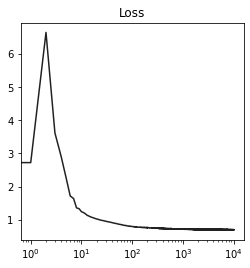

100%|██████████| 10000/10000 [4:41:51<00:00,  1.69s/it]

Model saved.
Trained on data equivalent to 10000000 solves.


In [ ]:
train(TrainConfig)
print(f"Trained on data equivalent to {TrainConfig.batch_size_per_depth * TrainConfig.num_train_steps} solves.")


## Inference

We test and compare on the DeepCubeA dataset

In [ ]:
%%capture
model.eval()

### Dataset: DeepCubeA

Downloading from GitHub

In [ ]:
if "DeepCubeA"!=os.getcwd().split("/")[-1]:
    if not os.path.exists('DeepCubeA'):
        !git clone -q https://github.com/forestagostinelli/DeepCubeA
    %cd ./DeepCubeA/

print('### Optimal Solver ###')
filename = 'data/puzzle15/test/data_0.pkl'
with open(filename, 'rb') as f:
    data_Optimal = pickle.load(f)

print(data_Optimal.keys())
solutions_Optimal, times_Optimal, num_nodes_Optimal = [
    data_Optimal[e] for e in ['solutions', 'times', 'num_nodes_generated']]
len_Optimal = [len(s) for s in solutions_Optimal]
len_Optimal_count = {i: len_Optimal.count(
    i) for i in range(min(len_Optimal), max(len_Optimal))}

print('No. of cases:', len(len_Optimal))

print('\n### DeepCubeA ###')

filename = 'results/puzzle15/results.pkl'
with open(filename, 'rb') as f:
    data_DeepCubeA = pickle.load(f)

print(data_DeepCubeA.keys())
solutions_DeepCubeA, times_DeepCubeA, num_nodes_DeepCubeA = [
    data_DeepCubeA[e] for e in ['solutions', 'times', 'num_nodes_generated']]
len_DeepCubeA = [len(s) for s in solutions_DeepCubeA]
len_DeepCubeA_count = {i: len_DeepCubeA.count(
    i) for i in range(min(len_DeepCubeA), max(len_DeepCubeA))}

print('No. of cases:', len(solutions_DeepCubeA))

%cd ../

/content/DeepCubeA
### Optimal Solver ###
dict_keys(['solutions', 'states', 'num_nodes_generated', 'times'])
No. of cases: 500

### DeepCubeA ###
dict_keys(['states', 'solutions', 'paths', 'times', 'num_nodes_generated'])
No. of cases: 500
/content


Convert optimal solutions to test scrambles

In [ ]:
# scrambles are the inverse of the optimal solutions
def solution2scramble(solution):
    return [env.pairing[m] for m in solution[::-1]]

test_scrambles = [solution2scramble(s) for s in solutions_Optimal]

print(f"""Example: {solutions_Optimal[0]} -> {test_scrambles[0]}""")

Example: ['L', 'L', 'D', 'D', 'R', 'U', 'U', 'R', 'D', 'D', 'R', 'D', 'L', 'L', 'U', 'U', 'L', 'U', 'R', 'D', 'R', 'R', 'D', 'L', 'D', 'L', 'U', 'U', 'R', 'U', 'L', 'D', 'D', 'R', 'U', 'L', 'L', 'U'] -> ['D', 'R', 'R', 'D', 'L', 'U', 'U', 'R', 'D', 'L', 'D', 'D', 'R', 'U', 'R', 'U', 'L', 'L', 'U', 'L', 'D', 'R', 'D', 'D', 'R', 'R', 'U', 'L', 'U', 'U', 'L', 'D', 'D', 'L', 'U', 'U', 'R', 'R']


### Beam Search

In [ ]:
def beam_search(
        env,
        model,
        max_depth,
        beam_width,
        __eval = SearchConfig.eval__,
        skip_redundant_moves=True,
    ):
    """
    Best-first search algorithm.
    Input:
        env: A scrambled instance of the given environment. 
        beam_width: Number of top solutions to return per depth.
        max_depth: Maximum depth of the search tree.
        __eval: Evaluation method for sorting nodes to expand, based on DNN outputs: 'softmax', 'logits', or 'cumprod'. 
        skip_redundant_moves: If True, skip redundant moves.
        ...
    Output: 
        if solved successfully:
            True, {'solutions':solution path, "num_nodes":number of nodes expanded, "times":time taken to solve}
        else:
            False, None
    """
    with torch.no_grad():
        # metrics
        num_nodes, time_0 = 0, time.time()
        candidates = [
            {"state":deepcopy(env.state), "path":[], "value":1.}
        ] # list of dictionaries

        for depth in range(max_depth+1):
            # TWO things at a time for every candidate: 1. check if solved & 2. add to batch_x
            batch_x = np.zeros((len(candidates), env.state.shape[-1]), dtype=np.int64)
            for i,c in enumerate(candidates):
                c_path, env.state = c["path"], c["state"]
                if c_path:
                    env.finger(c_path[-1])
                    num_nodes += 1
                    if env.is_solved():
                        return True, {'solutions':c_path, "num_nodes":num_nodes, "times":time.time()-time_0}
                batch_x[i, :] = env.state

            # after checking the nodes expanded at the deepest    
            if depth==max_depth:
                print("Solution not found.")
                return False, None

            # make predictions with the trained DNN
            batch_x = torch.from_numpy(batch_x).to(device)
            batch_p = model(batch_x).to("cpu").detach().numpy()

            # loop over candidates
            candidates_next_depth = []  # storage for the depth-level candidates storing (path, value, index).
            for i, c in enumerate(candidates):
                c_path = c["path"]
                value_distribution = batch_p[i, :] # output logits for the given state
                if __eval in ["softmax","cumprod"]:
                    value_distribution = softmax(value_distribution)
                    if __eval=="cumprod":
                        value_distribution *= c["value"] # multiply the cumulative probability so far of the expanded path

                for m, value in zip(env.moves_inference, value_distribution): # iterate over all possible moves.
                    # predicted value to expand the path with the given move.

                    # remove (physically) illegal moves, whether you like it or not
                    target_loc = np.where(c['state'].reshape(4, 4) == 0)
                    if m=="R":
                        if not target_loc[1]: # zero_index (empty slot) on the left
                            continue
                    elif m=="D":
                        if not target_loc[0]: # on the top
                            continue
                    elif m=="U":
                        if target_loc[0]==3: # on the bottom
                            continue
                    elif m=="L":
                        if target_loc[1]==3: # on the right
                            continue
                    if c_path:
                        if skip_redundant_moves:
                            # Two cancelling moves
                            if env.pairing[c_path[-1]] == m:
                                continue

                    # add to the next-depth candidates unless 'continue'd.
                    candidates_next_depth.append({
                        'state':deepcopy(c['state']),
                        "path": c_path+[m],
                        "value":value,
                    })

            # sort potential paths by expected values and renew as 'candidates'
            candidates = sorted(candidates_next_depth, key=lambda item: -item['value'])
            # if the number of candidates exceed that of beam width 'beam_width'
            candidates = candidates[:beam_width]


### Solve

100%|██████████| 500/500 [1:31:27<00:00, 10.98s/it]


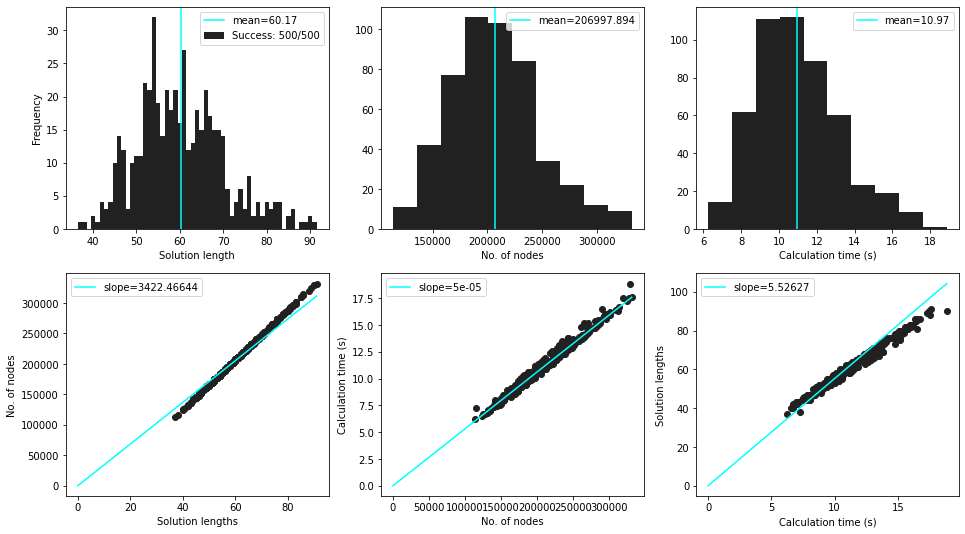

In [ ]:
result_all = {
    "solutions":[],
    "num_nodes":[],
    "times":[]
}
for scramble in tqdm(test_scrambles, position=0):
    # reset and scramble
    env.reset()
    for scramble_move in scramble:
        env.finger(scramble_move)
    # solve
    success, result = beam_search(env, model, SearchConfig.max_depth, SearchConfig.beam_width)
    if success:
        for k in result_all.keys():
            result_all[k].append(result[k])

plot_result(*result_all.values())


## Comparison to DeepCubeA

### Solution length vs No. of nodes

In [ ]:
num_nodes_ours = [e for e in result_all["num_nodes"] if e]
times_ours = [e for e in result_all["times"] if e]
len_ours = [len(e) for e in result_all["solutions"] if e]
len_ours_count = {i: len_ours.count(i) for i in range(min(len_ours), max(len_ours)+1)}


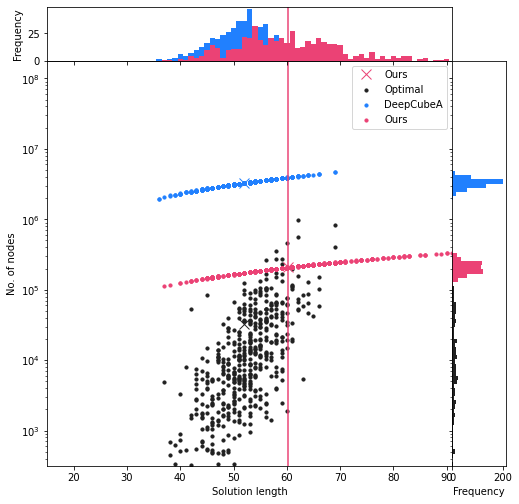

In [ ]:
left, width = 0.12, 0.75
bottom, height = 0.1, 0.75
spacing = 0.0

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height, width, 0.1]
rect_histy = [left + width, bottom, 0.1, height]

fig = plt.figure(figsize=(7.5, 7.5))
ax = fig.add_axes(rect_scatter)
ax.set_xlabel("Solution length")
ax.set_ylabel("No. of nodes")
ax.set_yscale("log")
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
ax_histx.set_ylabel("Frequency")
ax_histy.set_xlabel("Frequency")
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.set_xlim(15, max(len_ours))
ax_histx.set_xlim(15, max(len_ours))

ymax = 8.25
ax.set_ylim(10**2.5, 10**ymax)
ax_histy.set_ylim(10**2.5, 10**ymax)
bins_x = np.logspace(2.5, ymax, 100)

for k, (x, y) in {
        "Optimal": (len_Optimal, num_nodes_Optimal),
        "DeepCubeA": (len_DeepCubeA, num_nodes_DeepCubeA),
        "Ours": (len_ours, num_nodes_ours),
    }.items():
    ax.scatter(x, y, label=k, s=10)
    ax_histy.hist(y, bins=bins_x, orientation="horizontal")

for i, d in enumerate([len_Optimal_count, len_DeepCubeA_count, len_ours_count]):
    ax_histx.bar(list(d.keys()), list(d.values()), width=1)

ax_histx.axvline(np.mean(len_ours), color="#EB4275")
ax.axvline(np.mean(len_ours), color="#EB4275")

ax.plot(np.mean(len_Optimal), np.mean(num_nodes_Optimal), "x", markersize=10)
ax.plot(np.mean(len_DeepCubeA), np.mean(num_nodes_DeepCubeA), "x", markersize=10)
ax.plot(np.mean(len_ours), np.mean(num_nodes_ours), "x", label="Ours", markersize=10)
ax.legend()

plt.show()


### Calculation time (s) vs. Solution length

We compare time taken to solve test cases. 

In order to compare fairly our method to DeepCubeA, both of which are DNN-based, we obtain per-node time (s) and adjust ours to DeepCubeA.

Optimal:	7.30033653188447e-08
DeepCubeA:	2.6932907511788486e-06
Ours:	5.296495916735964e-05


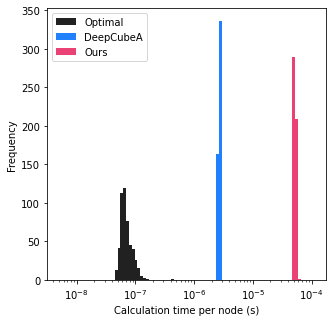

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_xlabel("Calculation time per node (s)")
ax.set_ylabel("Frequency")
ax.set_xscale("log")
ax.set_xlim(10**-8.5, 10**-3.75)
bins_x = np.logspace(-8.5, -3.75, 100)
for k, (n, t) in {
        "Optimal": (num_nodes_Optimal, times_Optimal),
        "DeepCubeA": (num_nodes_DeepCubeA, times_DeepCubeA),
        "Ours": (num_nodes_ours, times_ours),
    }.items():
    time_per_node = np.array(t) / np.array(n)
    ax.hist(time_per_node, bins=bins_x, label=k)
    print(f"{k}:\t{np.mean(time_per_node)}")
ax.legend()
plt.show()


In [ ]:
t_per_node_DeepCubeA = np.array(times_DeepCubeA) / np.array(num_nodes_DeepCubeA)
t_per_node_Ours = np.array(times_ours) / np.array(num_nodes_ours)
t_ratio = np.mean(t_per_node_Ours) / np.mean(t_per_node_DeepCubeA)
t_ratio

19.665518527539952

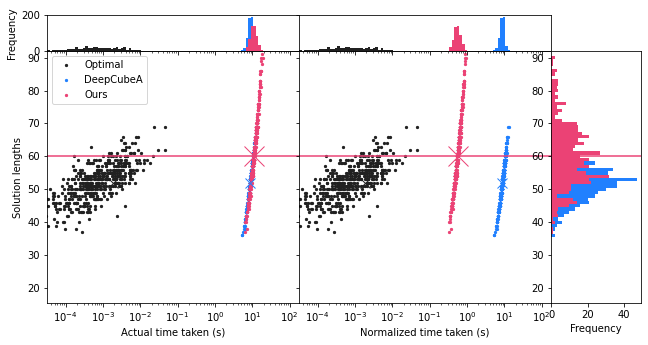

In [ ]:
left, width = 0.125, 0.35
bottom, height = 0.135, 0.70

rect_scatter = [left, bottom, width, height]
rect_scatter_j = [left + width, bottom, width, height]
rect_histx_0 = [left, bottom + height, width, 0.10]
rect_histx_1 = [left + width, bottom + height, width, 0.10]
rect_histy = [left + 2 * (width), bottom, 0.125, height]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes(rect_scatter)
ax.set_xlabel("Actual time taken (s)")
ax.set_ylabel("Solution lengths")
ax.set_xscale("log")
ax_j = fig.add_axes(rect_scatter_j)
ax_j.set_xlabel("Normalized time taken (s)")
ax_j.set_xscale("log")
ax_j.tick_params(axis="y", labelleft=False)

ax_histx_0 = fig.add_axes(rect_histx_0, sharex=ax)
ax_histx_0.set_ylabel("Frequency")
ax_histx_0.tick_params(axis="x", labelbottom=False)
ax_histx_1 = fig.add_axes(rect_histx_1, sharex=ax)
ax_histx_1.tick_params(axis="x", labelbottom=False)
ax_histx_1.tick_params(axis="y", labelleft=False)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
ax_histy.set_xlabel("Frequency")
ax_histy.tick_params(axis="y", labelleft=True)

bins_x = np.logspace(-4.5, 2.25, 100)
for k, (t, s) in {
        "Optimal": (times_Optimal, len_Optimal),
        "DeepCubeA": (times_DeepCubeA, len_DeepCubeA),
        "Ours": (times_ours, len_ours),
    }.items():
    ax.scatter(t, s, label=k, s=5)
    ax_histx_0.hist(t, bins=bins_x)
    if k == "Ours":
        t_justified = np.array(t) / t_ratio
        ax_histx_1.hist(t_justified, bins=bins_x)
        ax_j.scatter(t_justified, s, label=k, s=5)
    else:
        ax_histx_1.hist(np.array(t), bins=bins_x)
        ax_j.scatter(np.array(t), s, label=k, s=5)

for AX in [ax, ax_j]:
    AX.plot(np.mean(times_Optimal), np.mean(len_Optimal), "x", markersize=10)
    AX.plot(np.mean(times_DeepCubeA), np.mean(len_DeepCubeA), "x", markersize=10)
    AX.set_xlim(10**-4.5, 10**2.25)
    AX.set_ylim(15.5, max(len_ours) + 1)

for AX in [ax, ax_j, ax_histy]:
    AX.axhline(np.mean(len_ours), color="#EB4275")

for i, d in enumerate([len_Optimal_count, len_DeepCubeA_count, len_ours_count]):
    ax_histy.barh(list(d.keys()), list(d.values()), height=1)

ax.plot(np.mean(times_ours), np.mean(len_ours), "x", markersize=20)
ax_j.plot(np.mean(times_ours) / t_ratio, np.mean(len_ours), "x", markersize=20)

ax.legend()
plt.show()
